In [41]:
import pandas as pd
import numpy as np
import logging
import sys
import warnings
import seaborn as sns
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
import random
import joblib
from scipy.stats import skew, boxcox, norm, probplot

from matplotlib import pyplot as plt

from patsy import dmatrices

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import  StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from skater.model import InMemoryModel


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [3]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
log = logging.getLogger()


In [4]:
# Ignore any warning 
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn 

In [5]:
def _print_results(best, param):
    log.info('Mean Best Accuracy: {:2.2%}'.format(best))
    log.info('-'*60)
    log.info('Best Parameters:')
    log.info(param)
    log.info('-'*60)

## Load Dataset
Load dataset, create the quality label based on the quality score according to:

* Low for less or equal to 5
* Medium between 6 and 7
* High for more then 7


In [6]:
wines = pd.read_csv('winequalityN.csv')
wines['quality_label'] = wines.quality.apply(
    lambda quality: 'low' if quality < 5 else 'medium' if quality < 7 else 'hight')
wines = wines.sample(frac=1, random_state=101).reset_index(drop=True)

wines = wines.fillna(random.randint(0, 1))

In [7]:
wines.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_label
0,white,7.3,0.28,0.42,14.4,0.040,49.0,173.0,0.99940,3.28,0.82,9.0,7,hight
1,red,6.9,1.09,0.06,2.1,0.061,12.0,31.0,0.99480,3.51,0.43,11.4,4,low
2,red,9.5,0.46,0.24,2.7,0.092,14.0,44.0,0.99800,3.12,0.74,10.0,6,medium
3,red,8.2,0.31,0.40,2.2,0.058,6.0,10.0,0.99536,3.31,0.68,11.2,7,hight
4,white,7.9,0.28,0.41,4.9,0.058,31.0,153.0,0.99660,3.27,0.51,9.7,6,medium


## Cleaning, Transforming, Selection and Reduction

### skew
- skewness = 0 : normally distributed.
- skewness > 0 : more weight in the left tail of the distribution.
- skewness < 0 : more weight in the right tail of the distribution

In [8]:
numeric_features = list(wines.dtypes[(wines.dtypes != "str") & (wines.dtypes !='object')].index)
skewed_features = wines[numeric_features].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew': skewed_features})
skewness.head()

,Skew
chlorides,5.393277
sulphates,1.756502
volatile acidity,1.481256
residual sugar,1.434618
fixed acidity,1.384533


In [9]:
# Get only higest skewed features
skewness = skewness[abs(skewness) > 0.7].dropna()
log.info(f"There are {skewness.shape[0]} higest skewed numerical features to box cox transform")

INFO:root:There are 7 higest skewed numerical features to box cox transform


In [10]:
def QQ_plot(data, measure):
    """
    Creating quantile-quantil plot 
    """
    fig = plt.figure(figsize=(12,4))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    # Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.\
                   format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()

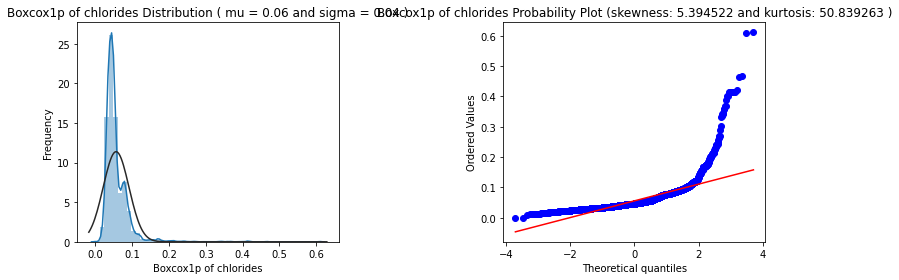

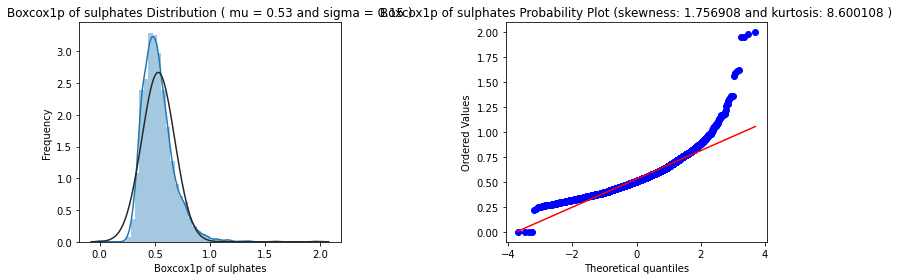

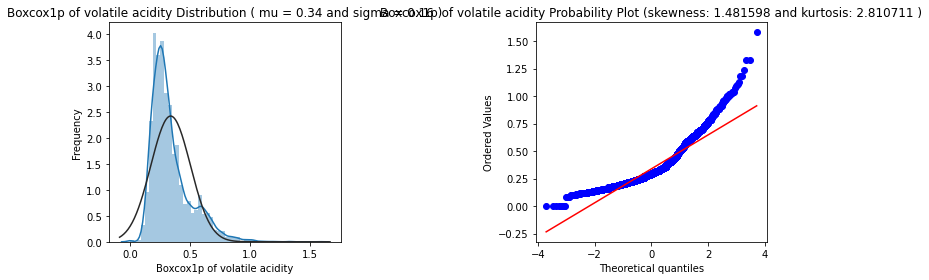

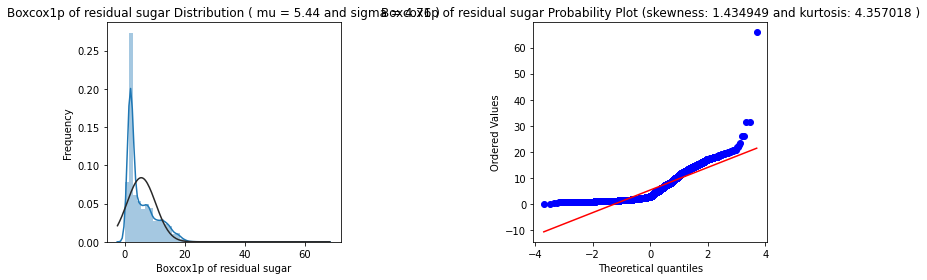

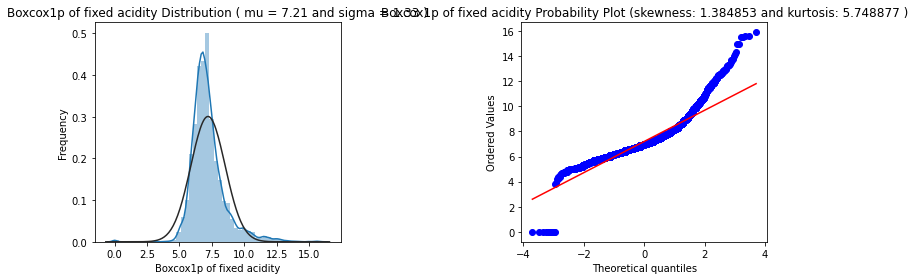

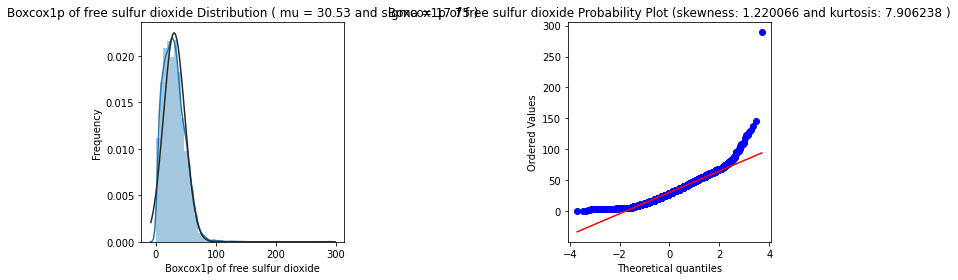

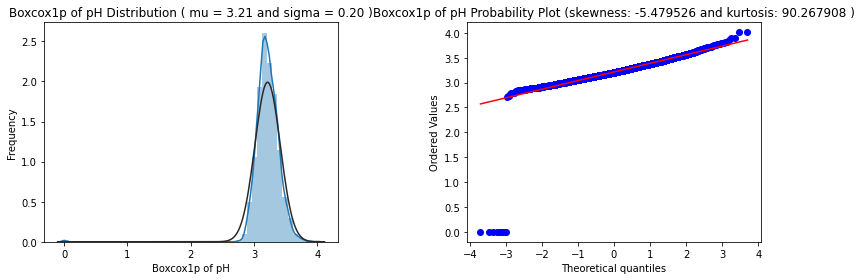

In [11]:
for index in skewness.index:
    QQ_plot(wines[index], (f'Boxcox1p of {index}'))

In [12]:
# re-shuffle records just to randomize data points
wines = wines.sample(frac=1, random_state=101).reset_index(drop=True)

class_tp = LabelEncoder()
y_tp = class_tp.fit_transform(wines.type.values) # 1 - White; 0 - Red
wines['color'] = y_tp

class_ql = {'low':0, 'medium': 1, 'high': 2}
y_ql = wines.quality_label.map(class_ql)
y_ql = y_ql.fillna(random.randint(0, 2))


### Variance inflation factors (VIF)

In [13]:
def VIF(predict, data, y):
   
    scale = StandardScaler(with_std=False)
    df = pd.DataFrame(scale.fit_transform(data), columns= cols)
    features = "+".join(cols)
    df['quality_label'] = y.values

    # get y and X dataframes based on this regression:
    y, X = dmatrices(predict + ' ~' + features, data = df, return_type='dataframe')

   # Calculate VIF Factors
    # For each X, calculate VIF and save in dataframe
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns

    # Inspect VIF Factors
    display(vif.sort_values('VIF Factor'))
    return vif

cols = wines.columns.str.replace(' ', '_')
df = wines.copy()
df.columns = cols
# Remove the not applied to the qualty classification task
cols = list(cols.drop(['type', 'quality_label', 'quality']))

vif = VIF('quality_label', df.loc[:, cols], y_ql)

,VIF Factor,features
0,1.000000,Intercept
9,1.500377,pH
10,1.537304,sulphates
3,1.606750,citric_acid
5,1.625989,chlorides
2,2.149111,volatile_acidity
6,2.229144,free_sulfur_dioxide
1,3.114358,fixed_acidity
7,4.034405,total_sulfur_dioxide
11,4.395904,alcohol


In [14]:
cols = wines.columns.str.replace(' ', '_')
df = wines.copy()
df.columns = cols
# Remove the higest correlations and run a multiple regression
cols = list(cols.drop(['type', 'quality_label', 'quality', 'residual_sugar', 'total_sulfur_dioxide']))

vif = VIF('quality_label', df.loc[:, cols], y_ql)

del df, vif

,VIF Factor,features
0,1.000000,Intercept
7,1.272592,pH
5,1.436759,free_sulfur_dioxide
8,1.442286,sulphates
3,1.590952,citric_acid
4,1.617844,chlorides
2,2.078275,volatile_acidity
1,2.106254,fixed_acidity
9,2.522936,alcohol
6,3.261542,density


## Wine Type Classifier Models

#### Logistic Regression

In [15]:
cols = wines.columns
cols = list(cols.drop(['type', 'quality_label', 'color', 'quality']))
X_train, X_test, y_train, y_test = train_test_split(wines.loc[:, cols], y_tp, test_size=0.20, random_state=101)

In [16]:
clf = Pipeline(
    [
        ('pca', PCA(random_state = 101)),
        ('clf', LogisticRegression(random_state=101))
    ]
)  

# a list of dictionaries to specify the parameters that we'd want to tune
n_components= [10, 12]
whiten = [True]
C =  [0.003, 0.009, 0.01]
tol = [0.001, 0.0001]

param_grid =[
    {
        'clf__C': C,
        'clf__solver': ['liblinear', 'saga'],
        'clf__penalty': ['l1', 'l2'],
        'clf__tol' : tol ,
        'clf__class_weight': [None, 'balanced'],
        'pca__n_components' : n_components,
        'pca__whiten' : whiten
    },
    
    {
        'clf__C': C,
        'clf__max_iter': [3, 9, 2, 7, 4],
        'clf__solver': ['newton-cg', 'sag', 'lbfgs'],
        'clf__penalty': ['l2'],
        'clf__tol' : tol ,
        'clf__class_weight': [None, 'balanced'] ,
        'pca__n_components' : n_components,
        'pca__whiten' : whiten
    }
]

gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
LR = Pipeline(
    [
        ('scl', StandardScaler()),
        ('gs', gs)
    ]
) 

LR.fit(X_train,y_train)


Fitting 5 folds for each of 456 candidates, totalling 2280 fits


[Parallel(n_jobs=-1)]: Done 836 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 2280 out of 2280 | elapsed:    9.6s finished


Pipeline(steps=[('scl', StandardScaler()),
                ('gs',
                 GridSearchCV(cv=5,
                              estimator=Pipeline(steps=[('pca',
                                                         PCA(random_state=101)),
                                                        ('clf',
                                                         LogisticRegression(random_state=101))]),
                              n_jobs=-1,
                              param_grid=[{'clf__C': [0.003, 0.009, 0.01],
                                           'clf__class_weight': [None,
                                                                 'balanced'],
                                           'clf__penalty': ['l1', 'l2'],
                                           'clf__solver': ['liblinear', 'saga'],
                                           'clf__tol': [0.001, 0.0001],
                                           'pca__n_components': [10, 12],
                          

In [17]:
_print_results(gs.best_score_,  gs.best_params_)

INFO:root:Mean Best Accuracy: 98.92%
INFO:root:------------------------------------------------------------
INFO:root:Best Parameters:
INFO:root:{'clf__C': 0.009, 'clf__class_weight': 'balanced', 'clf__max_iter': 4, 'clf__penalty': 'l2', 'clf__solver': 'sag', 'clf__tol': 0.001, 'pca__n_components': 10, 'pca__whiten': True}
INFO:root:------------------------------------------------------------


In [18]:
LR.predict(X_test)

array([0, 1, 1, ..., 1, 0, 1])

In [19]:
joblib.dump(gs.best_estimator_, 'LogisticRegression.pkl')

['LogisticRegression.pkl']

#### Deep Neural Network

In [20]:
# Define the scaler 
scaler = StandardScaler().fit(X_train)

# Scale the train set
X_train = scaler.transform(X_train)

# Scale the test set
X_test = scaler.transform(X_test)

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(11,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs=40

history = model.fit(X_train, y_train, epochs=epochs, batch_size=50, 
                            shuffle=True, validation_split=0.2, verbose=0)
history

In [21]:
ypred = model.predict_classes(X_test)
predictions = class_tp.inverse_transform(ypred) 
predictions

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array(['red', 'white', 'white', ..., 'white', 'red', 'white'],
      dtype=object)

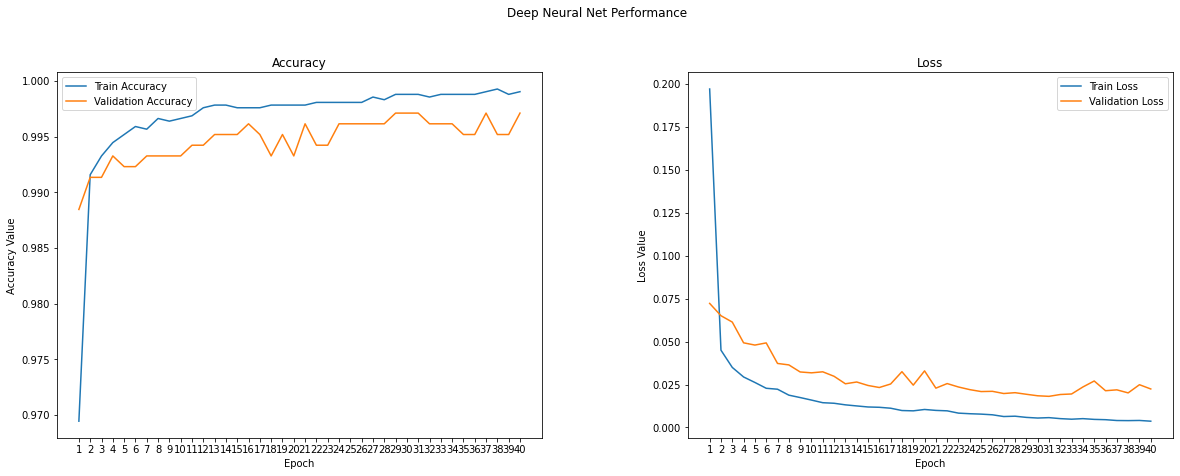

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1, epochs+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

### Wine Quality Classifier Models

In [23]:
wqp_class_labels = np.array(wines['quality_label'])
target_names = ['low', 'medium', 'high']

cols = wines.columns
cols = list(cols.drop(['type', 'quality_label', 'quality']))
X_train, X_test, y_train, y_test = train_test_split(wines.loc[:, cols], y_ql.values, test_size=0.20, random_state=101)

In [24]:
cols_clean = cols.copy()
cols_clean.remove('total sulfur dioxide')
cols_clean.remove('residual sugar')

#### Decision Tree Classifier

In [25]:
clf = Pipeline(
    [
        ('clf', DecisionTreeClassifier(random_state=101))
    ]
)  

# a list of dictionaries to specify the parameters that we'd want to tune
criterion = ['gini', 'entropy']
splitter = ['best']
max_depth = [8, 9, 10, 11] 
min_samples_leaf = [2, 3, 5]
class_weight = ['balanced', None] 

param_grid =[
    
    { 'clf__class_weight': class_weight,
     'clf__criterion': criterion,
     'clf__splitter': splitter,
     'clf__max_depth': max_depth,
     'clf__min_samples_leaf': min_samples_leaf
    }
]

gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
DT = Pipeline(
    [
        ('scl', StandardScaler()),
        ('gs', gs)
    ]
) 

DT.fit(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    3.6s finished


Pipeline(steps=[('scl', StandardScaler()),
                ('gs',
                 GridSearchCV(cv=5,
                              estimator=Pipeline(steps=[('clf',
                                                         DecisionTreeClassifier(random_state=101))]),
                              n_jobs=-1,
                              param_grid=[{'clf__class_weight': ['balanced',
                                                                 None],
                                           'clf__criterion': ['gini',
                                                              'entropy'],
                                           'clf__max_depth': [8, 9, 10, 11],
                                           'clf__min_samples_leaf': [2, 3, 5],
                                           'clf__splitter': ['best']}],
                              scoring='accuracy', verbose=1))])

In [26]:
_print_results(gs.best_score_,  gs.best_params_)

INFO:root:Mean Best Accuracy: 78.74%
INFO:root:------------------------------------------------------------
INFO:root:Best Parameters:
INFO:root:{'clf__class_weight': None, 'clf__criterion': 'entropy', 'clf__max_depth': 8, 'clf__min_samples_leaf': 2, 'clf__splitter': 'best'}
INFO:root:------------------------------------------------------------


In [27]:
joblib.dump(gs.best_estimator_, 'DecisionTreeClassifier.pkl')

['DecisionTreeClassifier.pkl']

In [28]:
clf = Pipeline(
    [
        ('clf', RandomForestClassifier(random_state=101))
    ]
)  

SEL = cols
n_components= [len(SEL)-2, len(SEL)-1, len(SEL)] 
whiten = [True, False]
criterion = ['gini', 'entropy']
class_weight = ['balanced', None] 
n_estimators = [155, 175]  
max_depth  = [20, None] 
min_samples_split = [2, 3, 4]
min_samples_leaf = [1]

param_grid =[
    
    { 
        'clf__criterion': criterion,
        'clf__n_estimators': n_estimators,
        'clf__min_samples_split': min_samples_split,
        'clf__max_depth': max_depth
    }
]

gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
RF = Pipeline(
    [ 
        ('scl', StandardScaler()),
        ('gs', gs)
    ]
) 

RF.fit(X_train,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.7min finished


Pipeline(steps=[('scl', StandardScaler()),
                ('gs',
                 GridSearchCV(cv=5,
                              estimator=Pipeline(steps=[('clf',
                                                         RandomForestClassifier(random_state=101))]),
                              n_jobs=-1,
                              param_grid=[{'clf__criterion': ['gini',
                                                              'entropy'],
                                           'clf__max_depth': [20, None],
                                           'clf__min_samples_split': [2, 3, 4],
                                           'clf__n_estimators': [155, 175]}],
                              scoring='accuracy', verbose=1))])

In [29]:
_print_results(gs.best_score_,  gs.best_params_)

INFO:root:Mean Best Accuracy: 84.84%
INFO:root:------------------------------------------------------------
INFO:root:Best Parameters:
INFO:root:{'clf__criterion': 'entropy', 'clf__max_depth': 20, 'clf__min_samples_split': 4, 'clf__n_estimators': 175}
INFO:root:------------------------------------------------------------


In [30]:
joblib.dump(gs.best_estimator_, 'RandomForestClassifier.pkl')

['RandomForestClassifier.pkl']

In [35]:
RF.predict(X_test)

array([0., 1., 0., ..., 0., 1., 1.])

#### XGBoost, LightGBM , CatBoost

In [ ]:
clf = Pipeline(
    [
        ('clf', xgb.XGBClassifier(
            base_score=0.5, colsample_bylevel=1, n_jobs=1,
            colsample_bytree=1, gamma=0.0001, max_delta_step=0, random_state=101, 
            silent=True, subsample=1)
        )
    ]
)

SEL = cols_clean
n_est = [112] 
max_depth = [15] 
learning_rate = [0.1] 
reg_lambda = [0.7] 
reg_alpha= [0.05]
booster = ['gbtree'] 
objective = ['binary:logistic'] 

param_grid = [
    
    { 
        'clf__n_estimators': n_est,
        'clf__booster': booster,
        'clf__objective': objective,
        'clf__learning_rate': learning_rate,
        'clf__reg_lambda': reg_lambda,
        'clf__reg_alpha': reg_alpha,
        'clf__max_depth': max_depth
    }
]

gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=3,
                  verbose=1, n_jobs=3)

XGBC = Pipeline(
    [ 
        ('scl', StandardScaler()),
        ('gs', gs)
 ]
) 

XGBC.fit(X_train,y_train)



In [ ]:
_print_results(gs.best_score_,  gs.best_params_)

In [ ]:
joblib.dump(gs.best_estimator_, 'XGBClassifier.pkl')

In [ ]:
clf = Pipeline(
    [
        ('clf', cb.CatBoostClassifier())
    ]
)  

# a list of dictionaries to specify the parameters that we'd want to tune
depth = [3,1,2,6,4,5,7,8,9,10]
iterations = [0.03,0.001,0.01,0.1,0.2,0.3]
learning_rate = [0.03,0.001,0.01,0.1,0.2,0.3]
l2_leaf_reg = [3,1,5,10,100]
border_count = [32,5,10,20,50,100,200]
ctr_border_count = [50,5,10,20,100,200]

param_grid = {
        'clf__depth': depth,
        'clf__iterations': iterations,
        'clf__learning_rate': learning_rate, 
        'clf__l2_leaf_reg': l2_leaf_reg,
        'clf__border_count': border_count,
        'clf__ctr_border_count': ctr_border_count
    }


gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
DT = Pipeline(
    [
        ('scl', StandardScaler()),
        ('gs', gs)
    ]
) 

DT.fit(X_train,y_train)

In [ ]:
_print_results(gs.best_score_,  gs.best_params_)

In [ ]:
joblib.dump(gs.best_estimator_, 'CatBoostClassifier.pkl')

In [ ]:
clf = Pipeline(
    [
        ('clf', lgb.LGBMClassifier())
    ]
)  

# a list of dictionaries to specify the parameters that we'd want to tune
learning_rate = [0.005]
n_estimators = [40]
num_leaves = [6,8,12,16]
boosting_type = ['gbdt']
objective = ['binary']
colsample_bytree = [0.65, 0.66]
subsample = [0.7,0.75]
reg_alpha = [1,1.2]
reg_lambda = [1,1.2,1.4]

param_grid = {
        'clf__learning_rate': learning_rate,
        'clf__n_estimators': n_estimators,
        'clf__num_leaves': num_leaves,
        'clf__boosting_type' : boosting_type,
        'clf__objective' : objective,
        'clf__colsample_bytree' : colsample_bytree,
        'clf__subsample' : subsample,
        'clf__reg_alpha' : reg_alpha,
        'clf__reg_lambda' : reg_lambda
    }


gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
DT = Pipeline(
    [
        ('scl', StandardScaler()),
        ('gs', gs)
    ]
) 

DT.fit(X_train,y_train)

In [ ]:
_print_results(gs.best_score_,  gs.best_params_)

In [ ]:
joblib.dump(gs.best_estimator_, 'LGBMClassifier.pkl')